In [1]:
import os
import sys

import numpy as np
import copy

from glob import glob
import argparse

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
base_dict = {
    'name':'',
    'file': '',
    'BRAM_18K': -1,
    'DSP48E': -1,
    'FF': -1,
    'LUT': -1,
    'URAM':-1,
    'LAT_min':-1,
    'LAT_max': -1,
    'INT_min': -1,
    'INT_max': -1,
    'ap_tot': -1,
    'ap_frac': -1,
    'ap_int': -1,
    'ap_quant': '',
    'ap_over': '',
    'strategy': '',
    'reuse': -1,
    'keras_auc': -1,
    'hls_auc': -1,
    'rel_auc': -1,
    'model': '',
    'static': 1,
    'mac_max': -1,
    'mac_min': -1,
    'npar': -1,
    'keras_mse_x': -1,
    'hls_mse_x': -1,
    'keras_mse_a': -1,
    'hls_mse_a': -1,
    'rel_mse_x': -1,
    'rel_mse_a': -1,
    'rel_mse_mse_x': -1,
    'rel_mse_mse_a': -1,
}

In [4]:
fpga = {}
fpga['DSP48E'] = 5520
fpga['BRAM_18K'] = 4320
fpga['FF'] = 1326720
fpga['LUT'] = 663360

In [5]:
label='ThesePlots'

In [6]:
models = []

In [7]:
models.append(
{
'name': "Best a-std model",
'dir': "MyTCN_CL20.4.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs",
'intbit': 6,
'lstyle': 'o-',
'fstyle': 'none',
})

models.append(
{
'name': "Smallest model",
'dir': "MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs",
'intbit': 4,
'lstyle': 'o--',
'fstyle': 'none',
})

# models.append(
# {
# 'name': "Smallest-1 model",
# 'dir': "MyTCN_CL7.4.4.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_DetMat_4Outputs",
# 'intbit': 4,
# 'lstyle': 'o:',
# 'fstyle': 'none',
# })


In [8]:
fld = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls/"

In [9]:
for imod,mod in enumerate(models):
    print(mod['name'])
    
    tfiles = glob(f"{fld}/{mod['dir']}/reports/*.txt")
    
    these_dicts = []
    
    for ff in tfiles:
        with open(ff, 'r') as hf:
            
            this_dict = copy.deepcopy(base_dict)
            this_dict['name'] = ff.split('/')[-1].replace('.txt', '')
            this_dict['file'] = ff

            this_dict['reuse'] = int(this_dict['name'].split('_reuse_')[-1].split('_')[0])
            this_dict['strategy'] = this_dict['name'].split('_reuse_')[-1].split('_')[1]

            modes = this_dict['name'].split('_reuse_')[0].replace('model_', '').split('.')

            if 'NonStatic' in ff: this_dict['static'] = 0

            this_dict['ap_tot'] = int(modes[0])
            this_dict['ap_int'] = int(modes[1])
            this_dict['ap_frac'] = this_dict['ap_tot'] - this_dict['ap_int']
            this_dict['ap_quant'] = 'std' if len(modes) < 3 else modes[2]
            this_dict['ap_over'] = 'std' if len(modes) < 3 else modes[3]
            if 'tcn' in ff.lower():
                this_dict['model'] = 'tcn'
            elif 'gru' in ff.lower():
                this_dict['model'] = 'gru'
            elif 'lstm' in ff.lower():
                this_dict['model'] = 'lstm'

            # this_dict['npar'] = n_params_gru if 'GRU' in ff or 'gru' in ff else n_params_lstm

            for line in hf:
                if 'function' in line or 'none' in line or 'dataflow' in line:
                    if '_' in line: continue

                    sline = line.split()
                    sline = [ sl.replace('|', '') for sl in sline ]

                    this_dict['LAT_min'] = float(sline[3])
                    this_dict['LAT_max'] = float(sline[6])

                    this_dict['INT_min'] = float(sline[9])
                    this_dict['INT_max'] = float(sline[10])

                    this_dict['mac_max'] = float(this_dict['npar'])/float(this_dict['INT_max'])
                    this_dict['mac_min'] = float(this_dict['npar'])/float(this_dict['INT_min'])

                    # if sline[4] != sline[7]:
                    #     print(sline[4], sline[7])
                    #     break

                    if 'ms' in sline[4]:
                        this_dict['LAT_min'] = this_dict['LAT_min']*1e3
                    if 'ns' in sline[4]:
                        this_dict['LAT_min'] = this_dict['LAT_min']*1e-3

                    if 'ms' in sline[7]:
                        this_dict['LAT_max'] = this_dict['LAT_max']*1e3
                    if 'ns' in sline[7]:
                        this_dict['LAT_max'] = this_dict['LAT_max']*1e-3

                    # if 'none' in lat_unit:
                    #     lat_unit = sline[4]
                    # else:
                    #     assert sline[4] == lat_unit

                if 'Total' in line and this_dict['FF'] == -1:
                    sline = line.split()
                    sline = [ sl.replace('|', '') for sl in sline ]

                    this_dict['BRAM_18K']  = int( sline[2] )
                    this_dict['DSP48E']    = int( sline[3] )
                    this_dict['FF']        = int( sline[4] )
                    this_dict['LUT']       = int( sline[5] )
                    this_dict['URAM']      = int( sline[6] )

                if 'KERAS_HLS_MSE_X' in line:
                    sline = line.split()
                    this_dict['rel_mse_mse_x'] = float(sline[1])
                elif 'KERAS_HLS_MSE_A' in line:
                    sline = line.split()
                    this_dict['rel_mse_mse_a'] = float(sline[1])
                elif 'KERAS_MSE_X' in line:
                    sline = line.split()
                    this_dict['keras_mse_x'] = float(sline[1])
                elif 'HLS_MSE_X' in line:
                    sline = line.split()
                    this_dict['hls_mse_x'] = float(sline[1])
                elif 'KERAS_MSE_A' in line:
                    sline = line.split()
                    this_dict['keras_mse_a'] = float(sline[1])
                elif 'HLS_MSE_A' in line:
                    sline = line.split()
                    this_dict['hls_mse_a'] = float(sline[1])

            this_dict['rel_mse_x'] = abs( this_dict['hls_mse_x'] ) / this_dict['keras_mse_x']
            this_dict['rel_mse_a'] = abs( this_dict['hls_mse_a'] ) / this_dict['keras_mse_a']
            this_dict['rel_auc'] = abs( this_dict['hls_auc'] ) / this_dict['keras_auc']
            these_dicts.append(this_dict)

    tdict = copy.deepcopy(base_dict)
    for kk in tdict:
        tdict[kk] = [ dd[kk] for dd in these_dicts]
    
    mod['pd'] = pd.DataFrame.from_dict(tdict)
    print(mod['pd'].head())

Best a-std model
                                           name  \
0   model_6.2_reuse_10_Resource_Static_BigTable   
1    model_4.0_reuse_2_Resource_Static_BigTable   
2  model_20.2_reuse_10_Resource_Static_BigTable   
3   model_16.2_reuse_1_Resource_Static_BigTable   
4   model_21.1_reuse_50_Latency_Static_BigTable   

                                                file  BRAM_18K  DSP48E     FF  \
0  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...       128       0  12381   
1  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...       410       0   7583   
2  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...       428    1556  39456   
3  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...      1654    3740  57328   
4  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...        -1      -1     -1   

     LUT  URAM  LAT_min  LAT_max  INT_min  ...   mac_min  npar  keras_mse_x  \
0  52417     0     5.07      5.5    941.0  ... -0.001063    -1      0.00064   
1  85643     0     4.70      5.

In [10]:
plot_loc = f'model_plots/{label}'

if not os.path.exists(plot_loc):
    os.makedirs(plot_loc)

In [11]:
def get_plot(pd_dict, st, reu, apint, var, max_x = 30, stat=1):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.static == stat) ].ap_frac.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.static == stat) ][var].to_numpy()
    sort_i = xi.argsort()
    x = np.array(xi[sort_i], dtype=int)
    y = yi[sort_i]
    y = y[x < max_x+1]
    x = x[x < max_x+1]
    return [x,y]

In [12]:
def get_plot_tot(pd_dict, st, reu, apint, var, model, max_x = 30, stat=1):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.static == stat) ].ap_tot.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.static == stat) ][var].to_numpy()
    sort_i = xi.argsort()
    x = np.array(xi[sort_i], dtype=int)
    y = yi[sort_i]
    y = y[x < max_x+1]
    x = x[x < max_x+1]
    return [x,y]

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])]
[array([ 2,  4,  6,

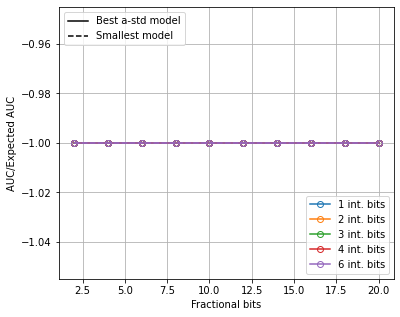

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([1201.83221523,  944.94171741, 1157.67163285,  615.49271615,
       1135.29863573, 1115.09713431, 1092.81119194, 1085.3493491 ,
       1082.41315611, 1081.88173076])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([248.67274179, 147.36895187, 142.97432527, 152.0987144 ,
       153.10003715, 153.40274306, 153.57706818, 153.67522882,
       153.69688599, 153.70043075])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([3738.67959833,  857.76460909,  573.07928642,  553.2331547 ,
        567.90623349,  595.06542311,  603.27144993,  605.55084993,
        606.00286866,  606.13507205])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([852.53037396, 222.40785851, 259.42133633, 312.5669581 ,
       332.62263853, 338.3185524 , 339.68219936, 340.01573951,
       340.09421024, 340.12308328])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([12771.72300951,  9820.71339469,   530.68657286,   429.77587552,
       

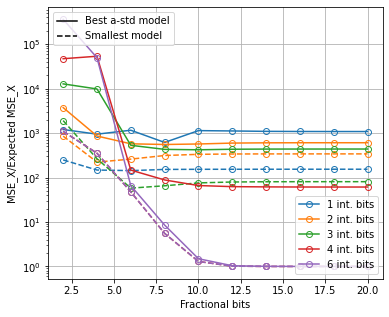

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([2177.10562497, 1337.00268344,  996.89016018,  623.61835173,
        805.97334923,  879.96730643,  901.77778444,  905.60289115,
        907.05990775,  907.53966468])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([415.88854254, 324.34329241, 176.85485935, 146.4309197 ,
       143.2901072 , 140.69318481, 140.85850254, 140.85168498,
       140.83842513, 140.83563671])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([6523.80368906, 2014.65992829, 1182.33770986,  631.75751263,
        617.02296096,  649.54075914,  660.7337543 ,  663.73274507,
        664.17514225,  664.40742268])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([1577.62490071,  568.54398393,  258.68751146,  268.39049607,
        276.32458336,  278.79729429,  278.82821575,  279.16614995,
        279.2614323 ,  279.2792058 ])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([22798.83964049,  2927.25031833,  5003.47518312,   718.7677027

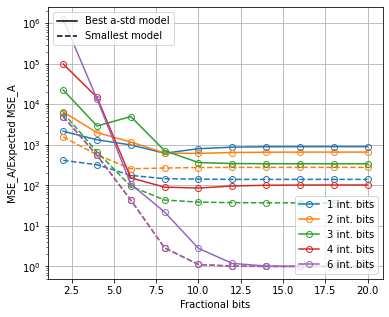

In [13]:
strat = 'Latency'

vars = ['rel_auc', 'rel_mse_x', 'rel_mse_a']
var_labs = [ r'AUC/Expected AUC', 'MSE_X/Expected MSE_X', 'MSE_A/Expected MSE_A']
reuse_to_plot=1

marker=['o', 'v', 's', '*', 'D', '^', 'P']

max_x = 22

for reuse in [reuse_to_plot]:
    
    for ivv,vv in enumerate(vars):
        

        fig, ax = plt.subplots(1,1,figsize=(6,5))
        
        lines = []
        llabels = []
        for iib,ib in enumerate([1, 2, 3, 4, 6]):
            for imod,mod in enumerate(models):
                tleg = f'{ib} int. bits' if imod==0 else None
                myplot = get_plot(mod['pd'], strat, reuse, ib, vv, max_x)
                print(myplot)
                ax.plot( myplot[0],myplot[1], mod['lstyle'], color=f'C{iib}', 
                        label=tleg, fillstyle=mod['fstyle'] )                
                
                if iib==0:
                    lines.append( mpl.lines.Line2D([0], [0], ls=mod['lstyle'][1:], color='black') )
                    llabels.append( mod['name'] )
        
        
        # plt.legend(title=f'Strat.: {strat},\n Reuse: {reuse}', frameon=False)
        ax.legend(frameon=True, loc='lower right')
        # plt.legend(frameon=False)
        ax.set_xlabel('Fractional bits')
        if 'LAT' in vv:
            ax.set_ylabel(var_labs[ivv]+f' (us)')
        else:
            ax.set_ylabel(var_labs[ivv])
        
        leg = mpl.legend.Legend(ax, lines, labels=llabels,
            loc='upper left', frameon=True)
        ax.add_artist(leg)
        
        if 'mse' in vv:
            ax.set_yscale('log')

        # plt.ylim(0,1.1)
        # plt.title(model_name, loc='left', fontweight="bold")
        plt.grid()
        plt.savefig(f"{plot_loc}/{vv}_{reuse}.pdf")
        plt.show()

In [17]:
reuses = [1, 2, 5, 10]
# reuses = [1, 5, 10, 50, 100]
reuses_labels = reuses

In [18]:
get_plot(models[0]['pd'], 'Latency', 1, 6, 'DSP48E', 22)

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
 array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])]

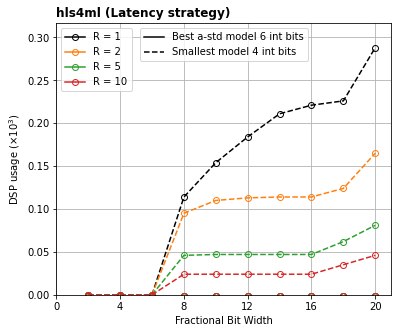

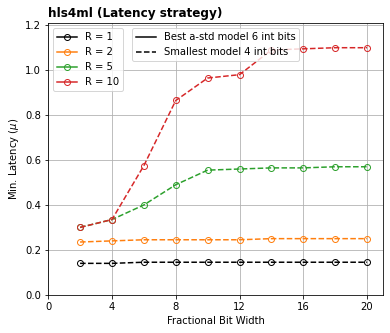

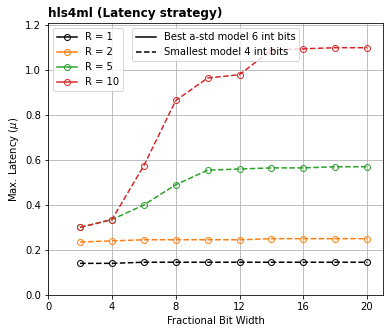

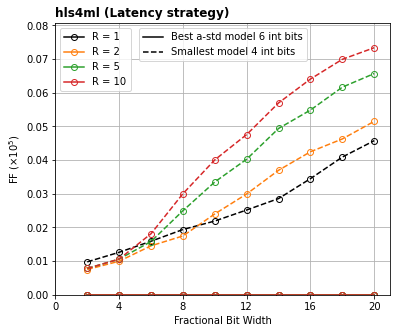

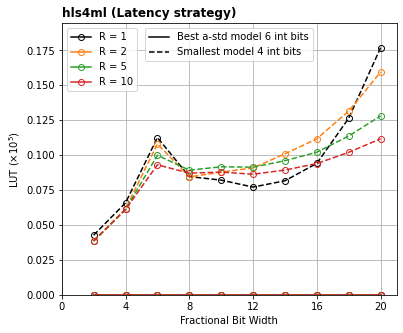

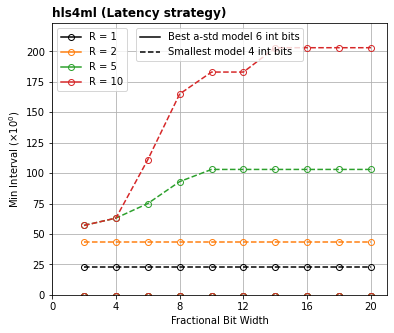

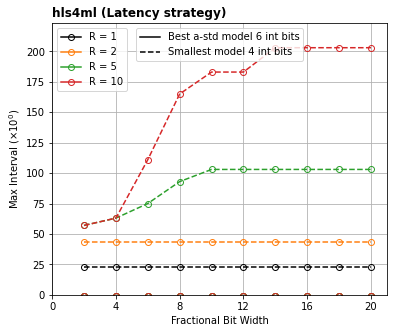

<ipython-input-19-c78b70b1135b>:50: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(pmin, pmax*1.1)


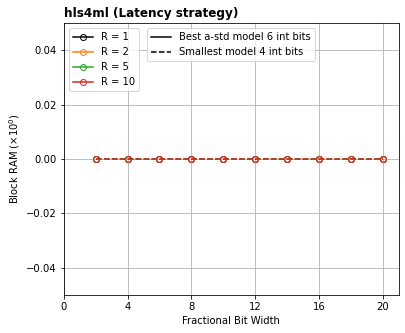

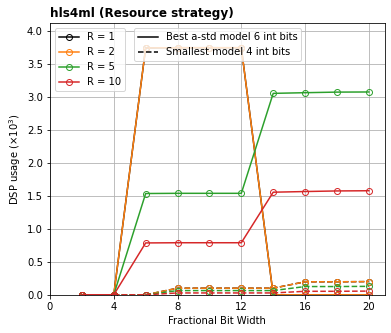

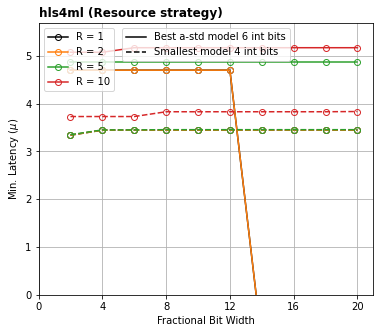

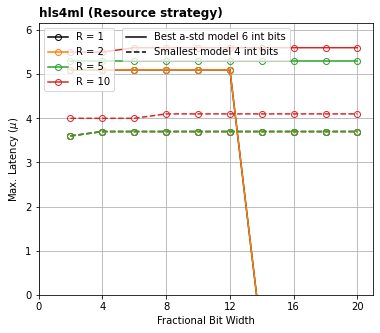

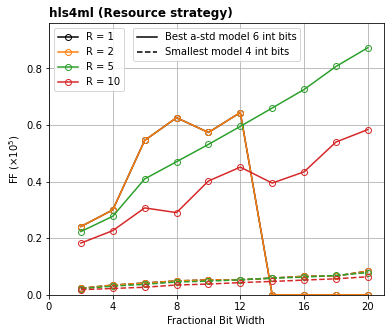

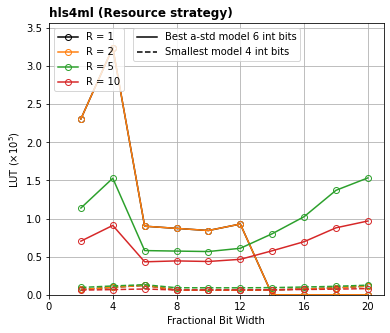

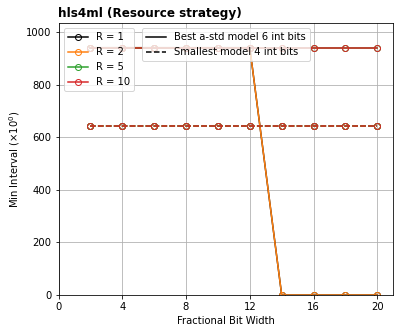

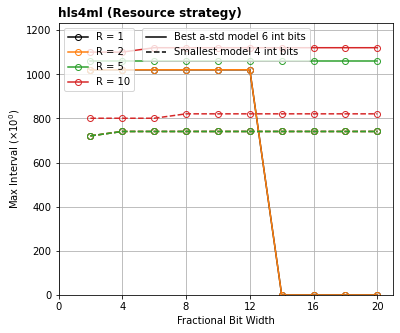

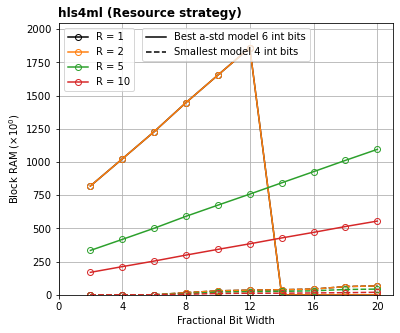

In [19]:
vars = ['DSP48E', f'LAT_min', f'LAT_max', 'FF', 'LUT', 'INT_min', 'INT_max', 'BRAM_18K']
var_labs = ['DSP usage', f'Min. Latency', f'Max. Latency', 'FF', 'LUT', 
            'Min Interval', 'Max Interval', 'Block RAM']
facts = [3, 0, 0, 5, 5, 0, 0, 0, 0, 3]

maxx = 20
    
for strat in ['Latency', 'Resource']:
    
    for ivv,vv in enumerate(vars):

        fig, ax = plt.subplots(1,1,figsize=(6,5))
        # plt.xlim(9,31)

        # for ire,reuse in enumerate([50, 100, 200, 500, 1000, 2000]):
        # for ire,reuse in enumerate([50, 100, 200, 1000]):
        pmax = 0
        pmin = 0
        
        lines = []
        llabels = []
        
        for ire,reuse in enumerate(reuses):

            col=f'C{ire}'
            if reuse == 1:
                col = 'black'

                
            for imod,mod in enumerate(models):
                tleg = f'R = {reuse}' if imod==0 else None
                myplot = get_plot(mod['pd'], strat, reuse, mod['intbit'], vv, max_x)
                ax.plot( myplot[0],myplot[1]/(10**facts[ivv]), mod['lstyle'], color=col, 
                        label=tleg, fillstyle=mod['fstyle'] )                
                
                if ire==0:
                    lines.append( mpl.lines.Line2D([0], [0], ls=mod['lstyle'][1:], color='black') )
                    llabels.append( mod['name'] + ' ' + str(mod['intbit']) + ' int bits'  )
                
                if len(myplot[1][myplot[1]>0]) < 1: continue
                
                if max(myplot[1][myplot[1]>0]/(10**facts[ivv])) > pmax:
                    pmax = max(myplot[1][myplot[1]>0]/(10**facts[ivv]))
                if min(myplot[1][myplot[1]>0]/(10**facts[ivv])) < pmin:
                    pmin = min(myplot[1][myplot[1]>0]/(10**facts[ivv]))


        ax.set_xticks(np.arange(0, maxx+1, 4.0))
        ax.set_xlim(0,maxx+1)
        ax.set_ylim(pmin, pmax*1.1)

        # ax.legend(title=f'{INTBIT} int. bits'+'\n'+f'Dense R = {dense_reuse}', frameon=True,
        #           loc='upper left')
        ax.legend(frameon=True,
                  loc='upper left')
        # plt.legend(frameon=False)
        ax.set_xlabel('Fractional Bit Width')
        if 'LAT' in vv:
            # ax.set_yscale('log')
            # unit = lat_unit.replace('u', '$\\mu$')
            ax.set_ylabel(var_labs[ivv] +f' ($\\mu$)')
        else:
            ax.set_ylabel(var_labs[ivv] +f' ($\\times 10^{str(facts[ivv])} $)')

        leg = mpl.legend.Legend(ax, lines, labels=llabels,
                loc='upper center', frameon=True)
                # bbox_to_anchor=(0.55, 1.), frameon=True)
        ax.add_artist(leg)

        # if vv in fpga:
        #     ax.plot([0,21], [fpga[vv]/(10**facts[ivv]), fpga[vv]/(10**facts[ivv])], '--', color='gray') 

        plt.title(f'hls4ml ({strat} strategy)', loc='left', fontweight="bold")
        plt.grid()
        plt.savefig(f"{plot_loc}/{vv}_{strat}.pdf", bbox_inches='tight')
        plt.show()